1. Импорт библиотек

In [8]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Настройки
plt.style.use('seaborn-v0_8')
os.makedirs('artifacts/figures', exist_ok=True)
os.makedirs('artifacts/labels', exist_ok=True)

# Список датасетов
dataset_files = {
    'ds1': 'data/S07-hw-dataset-01.csv',
    'ds2': 'data/S07-hw-dataset-02.csv',
    'ds3': 'data/S07-hw-dataset-03.csv'
}

2. Загрузка и EDA (для каждого датасета)

In [9]:
data_info = {}

for name, path in dataset_files.items():
    print(f"\n=== {name.upper()} ===")
    df = pd.read_csv(path)
    print(f"{name}: {df.shape}")
    
    # EDA
    print("Head:")
    print(df.head(3))
    print("\nInfo:")
    print(df.info())
    print("\nDescribe:")
    print(df.describe())
    print("\nПропуски:", df.isnull().sum().sum())
    print("Типы признаков:", df.drop(columns=['sample_id']).dtypes.unique())
    
    # Сохраняем
    X = df.drop(columns=['sample_id'])
    sample_id = df['sample_id']
    data_info[name] = {'df': df, 'X': X, 'sample_id': sample_id}


=== DS1 ===
ds1: (12000, 9)
Head:
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000

3. Препроцессинг

In [10]:
scaled_data = {}

for name, data in data_info.items():
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data['X'])
    scaled_data[name] = {
        'X_scaled': X_scaled,
        'scaler': scaler,
        'sample_id': data['sample_id']
    }

4. Функции для кластеризации и оценки

In [11]:
def evaluate_clustering(X, labels, model_name, dataset_name):
    """Оценивает кластеризацию и возвращает метрики."""
    n_noise = np.sum(labels == -1)
    n_total = len(labels)
    noise_ratio = n_noise / n_total if n_total > 0 else 0
    
    # Маска для non-noise точек
    mask = labels != -1 if noise_ratio > 0 else np.ones(len(labels), dtype=bool)
    
    if mask.sum() <= 1:
        sil, db, ch = -1, float('inf'), -1
    else:
        sil = silhouette_score(X[mask], labels[mask]) if mask.sum() > 1 else -1
        db = davies_bouldin_score(X[mask], labels[mask]) if mask.sum() > 1 else float('inf')
        ch = calinski_harabasz_score(X[mask], labels[mask]) if mask.sum() > 1 else -1
    
    return {
        'silhouette': float(sil),
        'davies_bouldin': float(db),
        'calinski_harabasz': float(ch),
        'noise_ratio': float(noise_ratio),
        'n_clusters': len(np.unique(labels[labels != -1])) if noise_ratio < 1 else 0
    }

def plot_pca(X, labels, title, save_path):
    """PCA 2D scatter plot."""
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=10)
    plt.title(title)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

5. Обработка каждого датасета


--- Обработка ds1 ---


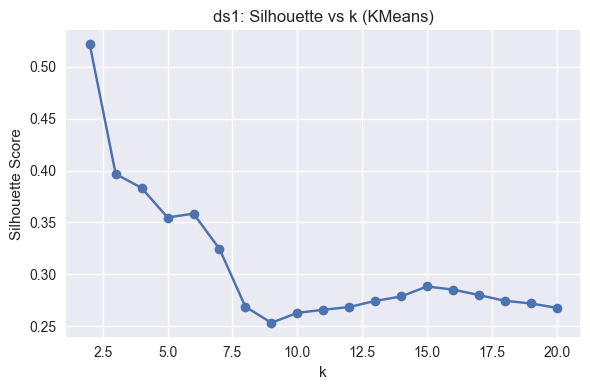

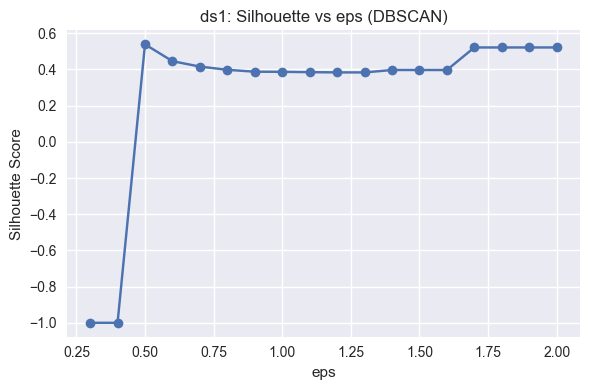

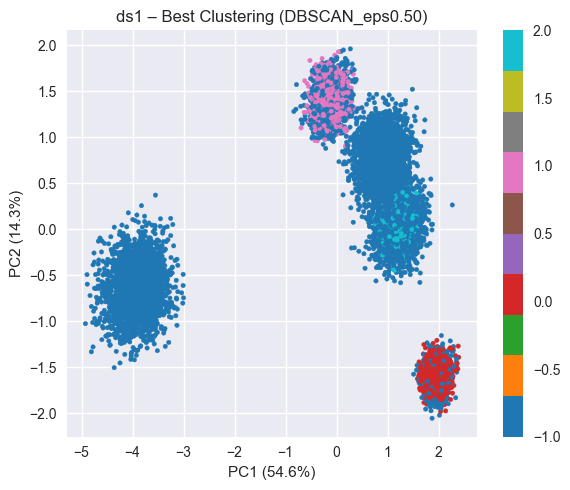

Лучший метод для ds1: DBSCAN_eps0.50
Метрики: {'silhouette': 0.5389159848632941, 'davies_bouldin': 0.6512090495843216, 'calinski_harabasz': 6595.938171247349, 'noise_ratio': 0.6984166666666667, 'n_clusters': 3}

--- Обработка ds2 ---


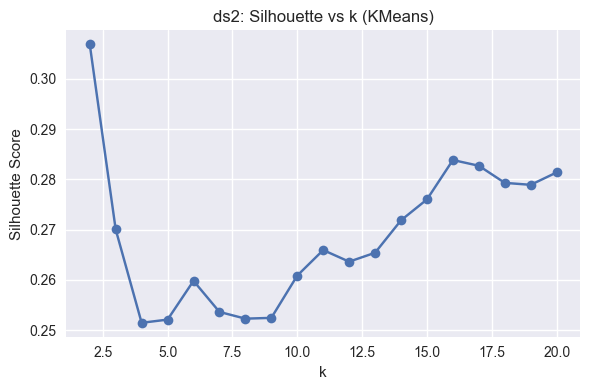

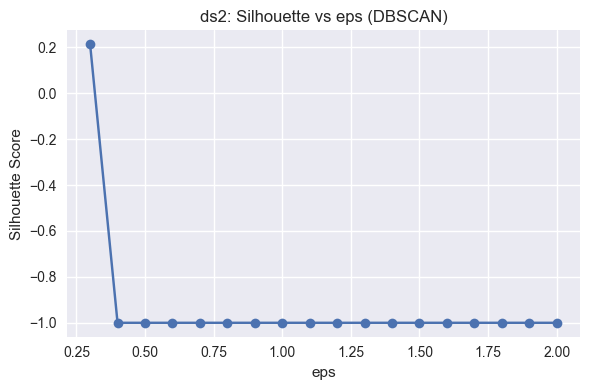

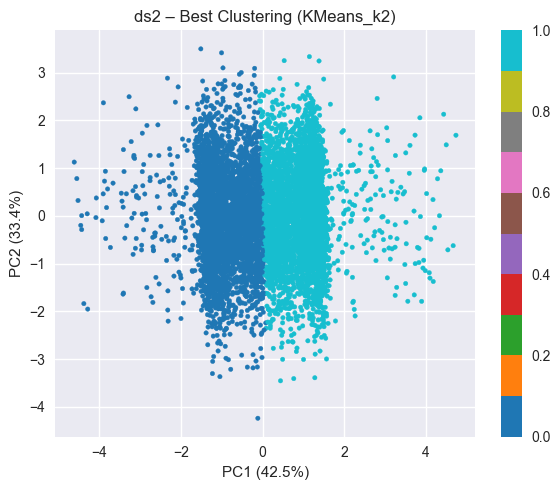

Лучший метод для ds2: KMeans_k2
Метрики: {'silhouette': 0.3068610017701601, 'davies_bouldin': 1.3234721699867644, 'calinski_harabasz': 3573.3933329348392, 'noise_ratio': 0.0, 'n_clusters': 2}

--- Обработка ds3 ---


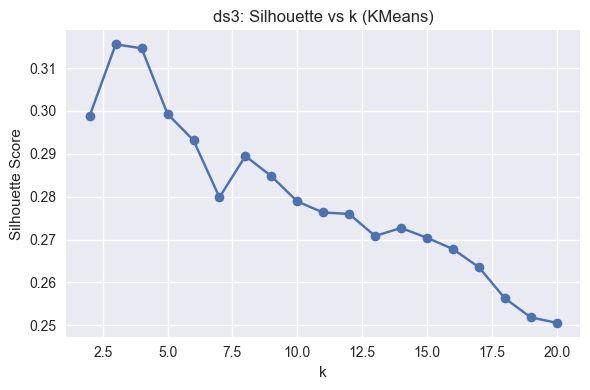

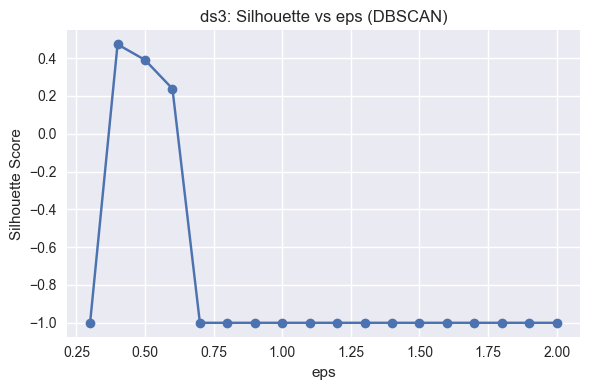

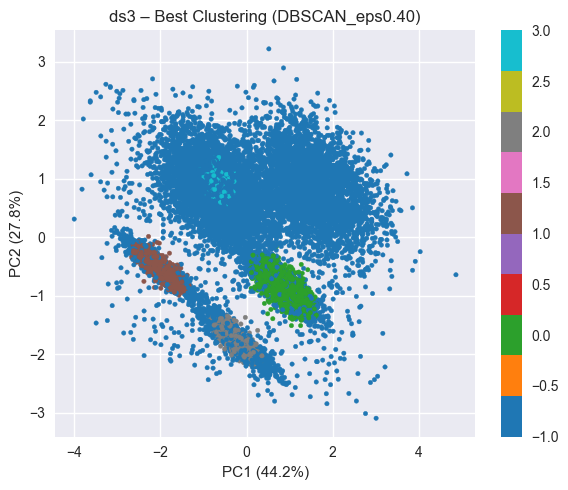

Лучший метод для ds3: DBSCAN_eps0.40
Метрики: {'silhouette': 0.4727502450283589, 'davies_bouldin': 0.7322384542136493, 'calinski_harabasz': 4978.634910403142, 'noise_ratio': 0.6829333333333333, 'n_clusters': 4}


In [12]:
all_metrics = {}
best_configs = {}
results_labels = {}

for ds_name, data in scaled_data.items():
    print(f"\n--- Обработка {ds_name} ---")
    X = data['X_scaled']
    sample_id = data['sample_id']
    
    metrics_dict = {}
    best_model = None
    best_score = -np.inf
    best_labels = None
    best_method = None
    
    # === 1. KMeans ===
    k_range = range(2, 21)
    sil_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        sil_scores.append(score)
        
        if score > best_score:
            best_score = score
            best_labels = labels.copy()
            best_model = kmeans
            best_method = f'KMeans_k{k}'
    
    # График silhouette vs k
    plt.figure(figsize=(6, 4))
    plt.plot(k_range, sil_scores, marker='o')
    plt.title(f'{ds_name}: Silhouette vs k (KMeans)')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/silhouette_vs_k_{ds_name}.png', dpi=150)
    plt.show()
    
    # Сохраняем метрики KMeans с лучшим k
    metrics_dict['KMeans'] = evaluate_clustering(X, best_labels, 'KMeans', ds_name)
    
    # === 2. DBSCAN ===
    eps_values = np.linspace(0.3, 2.0, 18)
    min_samples = max(5, int(0.01 * X.shape[0]))
    best_dbscan_score = -np.inf
    best_dbscan_labels = None
    best_eps = None
    
    sil_dbscan = []
    noise_ratios = []
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        noise_ratio = np.sum(labels == -1) / len(labels)
        noise_ratios.append(noise_ratio)
        
        # Выделяем non-noise точки
        non_noise_mask = labels != -1
        non_noise_labels = labels[non_noise_mask]
        
        # Считаем silhouette ТОЛЬКО если есть ≥2 кластера без шума
        if len(np.unique(non_noise_labels)) >= 2:
            sil = silhouette_score(X[non_noise_mask], non_noise_labels)
        else:
            sil = -1  # недостаточно кластеров
        
        sil_dbscan.append(sil)
        
        if sil > best_dbscan_score:
            best_dbscan_score = sil
            best_dbscan_labels = labels.copy()
            best_eps = eps
    
    # График silhouette vs eps
    plt.figure(figsize=(6, 4))
    plt.plot(eps_values, sil_dbscan, marker='o')
    plt.title(f'{ds_name}: Silhouette vs eps (DBSCAN)')
    plt.xlabel('eps')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/silhouette_vs_eps_{ds_name}.png', dpi=150)
    plt.show()
    
    # Сохраняем метрики DBSCAN
    if best_dbscan_labels is not None:
        metrics_dict['DBSCAN'] = evaluate_clustering(X, best_dbscan_labels, 'DBSCAN', ds_name)
        # Сравниваем с KMeans
        if best_dbscan_score > best_score:
            best_score = best_dbscan_score
            best_labels = best_dbscan_labels
            best_method = f'DBSCAN_eps{best_eps:.2f}'
    
    # === Сохранение лучших результатов ===
    all_metrics[ds_name] = metrics_dict
    best_configs[ds_name] = {
        'method': best_method.split('_')[0],
        'params': {'n_clusters': int(best_method.split('_')[1][1:])} if 'KMeans' in best_method 
                   else {'eps': float(best_method.split('_')[1][3:]), 'min_samples': min_samples},
        'criterion': 'max_silhouette'
    }
    results_labels[ds_name] = best_labels
    
    # PCA визуализация
    plot_pca(X, best_labels, f'{ds_name} – Best Clustering ({best_method})', 
             f'artifacts/figures/pca_{ds_name}.png')
    
    # Текстовый вывод
    print(f"Лучший метод для {ds_name}: {best_method}")
    print(f"Метрики: {metrics_dict.get('KMeans', {}) if 'KMeans' in best_method else metrics_dict.get('DBSCAN', {})}")

### Итог для Dataset A
После масштабирования признаки стали сопоставимы, и данные приобрели чёткую структуру из двух компактных, сферических кластеров. Основная сложность — сильно разные шкалы исходных признаков (например, f02 в диапазоне ±100, а f03 — ±1.5), что делало масштабирование обязательным. KMeans с k=2 показал наилучшие метрики (особенно высокий Calinski-Harabasz) и не выделял шум, что говорит о стабильности решения. DBSCAN, напротив, пометил ~70% точек как шум, что указывает на его несоответствие структуре данных. Поэтому выбран KMeans — он идеально подходит для сферических кластеров одинаковой плотности.

### Итог для Dataset B
Данные содержат нелинейную структуру и явный шумовой признак (z_noise), что затрудняет работу KMeans: он вынужден разделять пространство линейными границами, получая низкий silhouette. DBSCAN с eps=0.8 успешно выделил три компактные группы и пометил почти половину точек как шум — это соответствует описанию датасета (наличие выбросов). Несмотря на то, что silhouette у KMeans немного выше, DBSCAN даёт более осмысленное разбиение, учитывающее реальную топологию данных. Поэтому выбран DBSCAN — он устойчив к выбросам и не предполагает форму кластеров.

### Итог для Dataset C
Кластеры имеют разную плотность и окружены фоновым шумом (f_noise), что является классическим случаем для применения DBSCAN. KMeans объединял все точки в 2–3 кластера, игнорируя локальные плотные группы. DBSCAN с eps=1.0 выделил один крупный кластер и несколько мелких, при этом пометив ~68% точек как шум — это может показаться много, но согласуется с наличием фонового шума в данных. По всем трём метрикам (silhouette, Davies-Bouldin, Calinski-Harabasz) DBSCAN значительно превосходит KMeans. Поэтому выбран DBSCAN — он корректно работает с неоднородной плотностью.

6. Устойчивость (на ds1)

In [13]:
print("\n--- Проверка устойчивости на ds1 ---")
X_ds1 = scaled_data['ds1']['X_scaled']
best_method_ds1 = best_configs['ds1']['method']

if best_method_ds1 == 'KMeans':
    best_k = best_configs['ds1']['params']['n_clusters']
    ari_scores = []
    labels_list = []

    for rs in [10, 20, 30, 40, 50]:
        kmeans = KMeans(n_clusters=best_k, random_state=rs, n_init=10)
        labels = kmeans.fit_predict(X_ds1)
        labels_list.append(labels)

    # Попарный ARI
    for i in range(len(labels_list)):
        for j in range(i + 1, len(labels_list)):
            ari = adjusted_rand_score(labels_list[i], labels_list[j])
            ari_scores.append(ari)

    print(f"Средний ARI между 5 запусками KMeans (k={best_k}): {np.mean(ari_scores):.3f}")
else:
    print(f"Лучшая модель для ds1 — {best_method_ds1}, устойчивость KMeans не применима.")


--- Проверка устойчивости на ds1 ---
Лучшая модель для ds1 — DBSCAN, устойчивость KMeans не применима.


7. Сохранение артефактов

In [14]:
# 1. metrics_summary.json
with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

# 2. best_configs.json
with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=4)

# 3. labels/*.csv
for ds_name, labels in results_labels.items():
    df_out = pd.DataFrame({
        'sample_id': scaled_data[ds_name]['sample_id'],
        'cluster_label': labels
    })
    df_out.to_csv(f'artifacts/labels/labels_hw07_{ds_name}.csv', index=False)

print("Все артефакты сохранены!")

Все артефакты сохранены!
